# Predicting product cancelations for sales retention
Investigate machine learning techniques to predict the likely-hood of a product cancellation based on existing sales and amount spent in annual maintenance. To enable the targeting of retention resources and offers to those customers who are predicted as at risk. 

In [4]:
# get updated version on pandas
import pandas as pd
from distutils.version import LooseVersion, StrictVersion
if LooseVersion(pd.__version__) < LooseVersion("0.22.0"):
    !pip install --upgrade pandas
    pd.__version__
    print("pandas version was: " + pd.__version__ + " It has been updated, please restart the kernel")
else:
    print("pandas version is high enough")

pandas version is high enough


In [5]:
#some extra libs that we need in the page:
!pip install hypopt
#!pip install --upgrade seaborn
!pip install pdtransform

In [ ]:
# setup the notebook and import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_curve,
    accuracy_score
    )
from tabulate import tabulate
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
#from sklearn import cross_validation
from pdtransform import DFTransform, DFFeatureUnion
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
%matplotlib inline

# configure seaborn https://seaborn.pydata.org/
sns.set(color_codes=True)
colors = ["red","green", "greyish", "windows blue", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

#Get the data from the same folder as the notebook and test the pandas version
csvData = './ResultsGrid.csv'
isCancelledKey = 'isCancelled'
customerIdKey = 'customerId'
adminAreaKey = 'administrativeArea'
subCountryKey = 'subCountryArea'
countryKey = 'country'
avgDaysToPay='avgDaysToPay'

# The machine learning pipeline
![](https://cdn-images-1.medium.com/max/1600/1*2T5rbjOBGVFdSvtlhCqlNg.png)

In [8]:
pd.set_option('display.max_rows', 100)
dataFrame = pd.read_csv(csvData)
isCancelledIndex = dataFrame.columns.get_loc(isCancelledKey)
dataFrame.head()

,customerId,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,...,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12,administrativeArea,subCountryArea,country,firstInvoiceDate
0,215093,159.2,159.2,0.0,0.0,0.0,0.0,1,-1,0.0,...,False,False,False,False,False,True,none,none,United Kingdom,01/06/2018
1,215092,239.0,239.0,0.0,0.0,0.0,0.0,2,10,0.0,...,False,False,False,False,False,True,none,none,United Kingdom,25/05/2018
2,215091,239.0,239.0,0.0,0.0,0.0,0.0,2,33,0.0,...,False,False,False,False,False,True,WORCESTERSHIRE,West Midlands,United Kingdom,25/05/2018
3,215090,125.0,125.0,0.0,0.0,0.0,0.0,2,35,0.0,...,False,False,False,False,False,True,BEXLEY,London,United Kingdom,24/05/2018
4,215089,125.0,125.0,0.0,0.0,0.0,0.0,2,35,0.0,...,False,False,False,False,False,True,BEXLEY,London,United Kingdom,24/05/2018


In [9]:
dataFrame = dataFrame.infer_objects()

In [10]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4676 entries, 0 to 4675
Data columns (total 27 columns):
customerId              4676 non-null int64
amountTotal             4676 non-null float64
salesTotal              4676 non-null float64
annualTotal             4676 non-null float64
monthlyTotalProduct1    4676 non-null float64
monthlyTotalProduct2    4676 non-null float64
extraItemsTotal         4676 non-null float64
monthsSinceStarted      4676 non-null int64
avgDaysToPay            4676 non-null int64
creditedAmount          4676 non-null float64
isCancelled             4676 non-null bool
hasProduct1             4676 non-null bool
hasProduct2             4676 non-null bool
hasProduct3             4676 non-null bool
hasProduct4             4676 non-null bool
hasProduct5             4676 non-null bool
hasProduct6             4676 non-null bool
hasProduct7             4676 non-null bool
hasProduct8             4676 non-null bool
hasProduct9             4676 non-null bool
hasProduc

In [11]:
dataFrame.describe(include='all')

,customerId,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,...,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12,administrativeArea,subCountryArea,country,firstInvoiceDate
count,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,...,4676,4676,4676,4676,4676,4676,4676,4676,4676,4676
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,217,15,11,1400
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,none,North West,United Kingdom,30/11/2009
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4663,4646,4675,3991,4616,3293,244,1040,4550,82
mean,46900.834474,8199.874506,1091.890119,2638.875297,1719.273641,2563.909930,185.912380,62.047049,55.949102,201.173556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,67281.977821,13508.391594,2142.141606,4175.236029,4170.699589,6703.879866,941.121206,46.325072,184.911668,1290.280499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-10162.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3808.750000,657.000000,149.000000,240.000000,0.000000,0.000000,0.000000,22.000000,23.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,11919.500000,2650.000000,310.000000,1000.000000,0.000000,121.415000,0.000000,54.000000,41.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,38661.000000,9256.892500,897.000000,3150.000000,964.875000,2123.912500,0.000000,96.000000,67.250000,1.850000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#Describe the boolean cols, including the dependant `isCancelled` col
#dataFrame.describe(include=['bool'])
booltypes = dataFrame.select_dtypes(include=['bool'])
booltypes.apply(pd.Series.value_counts)

,isCancelled,hasProduct1,hasProduct2,hasProduct3,hasProduct4,hasProduct5,hasProduct6,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12
False,2600,2798,1802,4676.0,4372,4675,4676.0,4663,4646,4675,3991,4616,3293
True,2076,1878,2874,NaN,304,1,NaN,13,30,1,685,60,1383


### Checking for missing values

In [13]:
# from https://stackoverflow.com/a/44702024
nans = lambda df: df[df.isnull().any(axis=1)]
nans(dataFrame)

# Remove if found above - none found...
# drop the rows where values are nan and return the new dataframe
# dataFrame = dataFrame.dropna(axis=0)

,customerId,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,...,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12,administrativeArea,subCountryArea,country,firstInvoiceDate


In [14]:
# Find correlations and sort
# dataFrame.corr()[isCancelledKey].sort_values()
corr_matrix = dataFrame.corr()
corr_matrix[isCancelledKey].sort_values(ascending=False)

isCancelled             1.000000
hasProduct2             0.247663
hasProduct1             0.189850
hasProduct4             0.087349
creditedAmount          0.064485
salesTotal              0.030795
hasProduct7             0.026391
avgDaysToPay            0.021927
monthlyTotalProduct1    0.016987
hasProduct5            -0.013069
hasProduct9            -0.013069
annualTotal            -0.022727
hasProduct8            -0.034066
amountTotal            -0.064680
hasProduct11           -0.067456
monthsSinceStarted     -0.068659
monthlyTotalProduct2   -0.117760
extraItemsTotal        -0.134093
customerId             -0.163728
hasProduct10           -0.310549
hasProduct12           -0.369712
hasProduct3                  NaN
hasProduct6                  NaN
Name: isCancelled, dtype: float64

In [15]:
# heatmap of correlations
corrDf = dataFrame.drop(['firstInvoiceDate',customerIdKey,adminAreaKey,subCountryKey,countryKey], axis=1)
corr = corrDf.corr()
corrDf.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,isCancelled,hasProduct1,hasProduct2,hasProduct3,hasProduct4,hasProduct5,hasProduct6,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12
amountTotal,1.0,0.58,0.78,0.8,0.82,0.18,0.63,-0.087,0.11,-0.065,0.49,0.2,nan,0.19,-0.0035,nan,0.012,0.15,-0.0078,0.027,-0.036,-0.23
salesTotal,0.58,1.0,0.56,0.36,0.26,0.12,0.27,-0.064,0.17,0.031,0.34,0.1,nan,0.089,-0.0075,nan,0.0058,0.4,-0.0048,-0.0059,-0.028,-0.15
annualTotal,0.78,0.56,1.0,0.58,0.4,0.11,0.62,-0.083,0.16,-0.023,0.46,0.16,nan,0.17,0.0081,nan,0.012,0.38,-0.0072,-0.011,-0.042,-0.24
monthlyTotalProduct1,0.8,0.36,0.58,1.0,0.5,0.055,0.57,-0.089,0.055,0.017,0.5,0.16,nan,0.2,-0.0059,nan,-0.014,-0.033,-0.006,-0.022,-0.038,-0.21
monthlyTotalProduct2,0.82,0.26,0.4,0.5,1.0,0.079,0.42,-0.046,0.021,-0.12,0.27,0.15,nan,0.11,-0.0056,nan,0.016,-0.031,-0.0056,0.071,-0.014,-0.13
extraItemsTotal,0.18,0.12,0.11,0.055,0.079,1.0,0.14,-0.012,0.048,-0.13,0.067,0.11,nan,0.029,-0.0029,nan,0.058,-0.016,-0.0023,0.049,-0.0056,-0.024
monthsSinceStarted,0.63,0.27,0.62,0.57,0.42,0.14,1.0,-0.081,0.064,-0.069,0.43,0.44,nan,0.17,0.028,nan,-0.021,-0.036,0.035,-0.039,-0.05,-0.33
avgDaysToPay,-0.087,-0.064,-0.083,-0.089,-0.046,-0.012,-0.081,1.0,0.052,0.022,-0.12,-0.044,nan,-0.045,-0.003,nan,-0.0099,0.013,0.0048,-0.014,0.004,0.078
creditedAmount,0.11,0.17,0.16,0.055,0.021,0.048,0.064,0.052,1.0,0.064,0.049,0.037,nan,0.021,-0.0023,nan,0.0068,0.21,0.0034,-0.021,-0.013,-0.051
isCancelled,-0.065,0.031,-0.023,0.017,-0.12,-0.13,-0.069,0.022,0.064,1.0,0.19,0.25,nan,0.087,-0.013,nan,0.026,-0.034,-0.013,-0.31,-0.067,-0.37


In [16]:
corrDf.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,isCancelled,hasProduct1,hasProduct2,hasProduct3,hasProduct4,hasProduct5,hasProduct6,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12
amountTotal,1.0,0.49,0.9,0.7,0.69,0.17,0.8,-0.18,0.24,0.033,0.58,0.43,nan,0.16,0.0064,nan,0.003,0.1,-0.0088,-0.002,-0.039,-0.38
salesTotal,0.49,1.0,0.36,0.34,0.3,0.16,0.23,0.013,0.16,-0.12,0.25,0.11,nan,0.085,-0.02,nan,-0.031,0.13,0.0028,0.081,0.011,0.057
annualTotal,0.9,0.36,1.0,0.65,0.55,0.13,0.8,-0.19,0.26,0.098,0.55,0.39,nan,0.19,0.016,nan,0.026,0.089,-0.0063,-0.05,-0.052,-0.38
monthlyTotalProduct1,0.7,0.34,0.65,1.0,0.36,-0.021,0.56,-0.37,0.13,0.13,0.83,0.25,nan,0.27,0.0092,nan,0.0017,-0.055,0.0085,-0.033,-0.053,-0.34
monthlyTotalProduct2,0.69,0.3,0.55,0.36,1.0,0.18,0.66,0.037,0.19,-0.14,0.22,0.48,nan,0.055,-0.015,nan,-0.023,-0.085,-0.015,0.15,0.011,-0.26
extraItemsTotal,0.17,0.16,0.13,-0.021,0.18,1.0,0.17,0.099,0.2,-0.17,-0.0012,0.19,nan,-0.014,-0.005,nan,0.022,-0.02,0.037,0.096,0.015,-0.047
monthsSinceStarted,0.8,0.23,0.8,0.56,0.66,0.17,1.0,-0.039,0.24,-0.019,0.41,0.5,nan,0.15,0.023,nan,-0.024,-0.033,0.024,-0.061,-0.055,-0.36
avgDaysToPay,-0.18,0.013,-0.19,-0.37,0.037,0.099,-0.039,1.0,0.17,-0.097,-0.39,-0.0075,nan,-0.15,-0.015,nan,-0.043,0.056,0.019,0.03,0.026,0.17
creditedAmount,0.24,0.16,0.26,0.13,0.19,0.2,0.24,0.17,1.0,0.12,0.087,0.21,nan,0.048,-0.0085,nan,0.0093,0.028,0.027,-0.0014,-0.01,-0.12
isCancelled,0.033,-0.12,0.098,0.13,-0.14,-0.17,-0.019,-0.097,0.12,1.0,0.19,0.25,nan,0.087,-0.013,nan,0.026,-0.034,-0.013,-0.31,-0.067,-0.37


### Pipeline

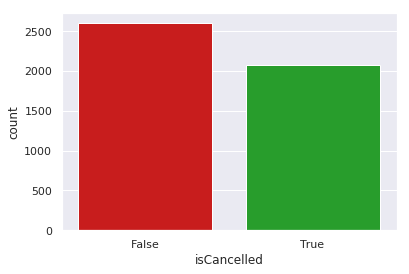

In [17]:
sns.countplot(x=isCancelledKey,data=dataFrame)

In [27]:
def getTrainTestSplit(df):
    #remove the dependant variable and columns that have no value in training
    data = df.drop([isCancelledKey], axis=1)
    X_train, X_test, y_train, y_test = train_test_split( data, df[isCancelledKey], test_size=0.33, random_state=42, stratify=df[isCancelledKey])
    
    print('y_train class distribution')
    print(y_train.value_counts(normalize=True))
    print('y_test class distribution')
    print(y_test.value_counts(normalize=True))
    
    return X_train, X_test, y_train, y_test

In [19]:
def printConfusionMatrix(confusion_matrix, figsize = (10,7), fontsize=14):
    classNames = ['false', 'true']
    df_cm = pd.DataFrame(
        confusion_matrix, index=classNames, columns=classNames, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [20]:
def printDescribe(afterString, df):
    print(f"{afterString} - Number of features {len(df.columns)}")

In [21]:
def getOneHotEncodeData(df):
    categoryFeatures = [adminAreaKey, subCountryKey,countryKey]
    oneHotDataframe = pd.get_dummies(df,columns=categoryFeatures, dummy_na=True)
    return oneHotDataframe

In [22]:
def printClassificationReport(y_test, y_pred):
    #storeResults
    #accuracy = accuracy_score(y_test, y_pred)  
    #rocauc = roc_auc_score(y_test, probs[1])  
    #confMatrix = confusion_matrix(y_test, y_pred)  
    #classificationReport = classification_report(y_test, y_pred)  
    #precision = precision_score(y_test, y_pred, pos_label=1)  
    #recall = recall_score(y_test, y_pred, pos_label=1)  
    #f1 = f1_score(y_test, y_pred, pos_label=1)
    print(classification_report(y_test, y_pred))

In [30]:
def GridSearchCVOnPipeline(X, y, pipeline, param_grid, refit_score='precision_score'):
    skf = StratifiedKFold(n_splits=3)
    grid = GridSearchCV(
        pipeline, 
        cv=skf,  
        param_grid=param_grid,
        scoring=scorers, 
        refit=refit_score,
        return_train_score=True, 
        n_jobs=-1
    )
    bestModel = grid.fit(X, y)
    #mean_scores = np.array(grid.cv_results_['mean_test_score'])
    #print(mean_scores)
    
    return bestModel
    
def BestModelScore(X_test, y_test, grid, refit_score='precision_score'):
    scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
    }
    
    y_pred = grid.predict(X_test.values)

    print('Best params for {}'.format(refitScore))
    print(grid_search.best_params_)

    print('\nConfusion matrix for {} on the test data:'.format(refitScore))
    print(pd.DataFrame(
            confusion_matrix(y_test, y_pred),
            columns=['pred_neg', 'pred_pos'], 
            index=['neg', 'pos'])
         )
    #printConfusionMatrix(confusion_matrix(y_test,y_pred))
    #printClassificationReport(y_test, y_pred)
    
    return grid

# Baseline regression

In [26]:
# train test data, hold back test dataset
X_train, X_test, y_train, y_test = getTrainTestSplit(dataFrame)

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64


In [29]:
C = uniform(loc=0, scale=4).rvs(10)
refitScore = 'precision_score'
param_grid = [
    {
        'classifier__C': C,
        'classifier__penalty':['l1', 'l2']
    }
]

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('One hot encode', DFTransform(getOneHotEncodeData)),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
])
clfPipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('classifier', LogisticRegression())
])

transformedDf = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDf, y_train, clfPipeline, param_grid, refitScore)
BestModelScore(X_test, y_test, bestModel, refitScore)

#now do this https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

[0.76117497 0.75862069 0.77203065 0.75862069 0.76277139 0.75925926
 0.76277139 0.75925926 0.76181354 0.75893997 0.76213282 0.75893997
 0.76787995 0.75862069 0.76404853 0.75925926 0.76117497 0.75862069
 0.76340996 0.75925926]


NameError: name 'clf' is not defined

In [50]:
regressor = LogisticRegression()
printDescribe("Beginning", X_train)

df = X_train.drop([customerIdKey,'firstInvoiceDate'], axis=1)
printDescribe("After dropping", df)

df = df.select_dtypes(exclude=['object'])
printDescribe("After excluded all but objects", df)

clf = trainAndShowGridSearchCV(df,y_train, regressor)
clf.score(X_test, y_test)

Beginning - Number of features 26
After dropping - Number of features 24
After excluded all but objects - Number of features 21
Best Penalty: l1
Best C: 0.7135200134752262


ValueError: could not convert string to float: '29/11/2011'

# Start feature engineering

Beginning - Number of features 27
After dropping - Number of features 24
After One hot encoding - Number of features 267
After excluded all but objects - Number of features 267
             precision    recall  f1-score   support

      False       0.81      0.81      0.81       861
       True       0.76      0.76      0.76       683

avg / total       0.79      0.79      0.79      1544



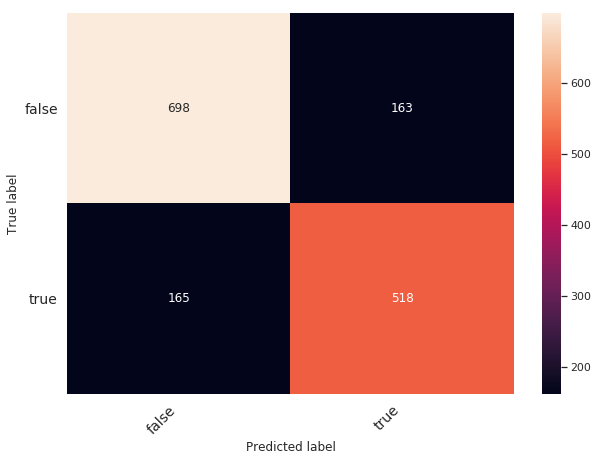

In [27]:
regressor = LogisticRegression()

printDescribe("Beginning", dataFrame)

df = dataFrame.drop([customerIdKey,'firstInvoiceDate','monthlyTotalProduct2'], axis=1)
printDescribe("After dropping", df)

df = getOneHotEncodeData(df)
printDescribe("After One hot encoding",df)

df = df.select_dtypes(exclude=['object'])
printDescribe("After excluded all but objects", df)
                     
splitTrainAndShow(df,regressor)

# Skewed data

In [165]:
skewDf = dataFrame.skew(numeric_only="true")
skewDf = skewDf[lambda x : (x > 3.0) | (x < -3.0)]
skewDf
#skewDf.index

Index(['amountTotal', 'salesTotal', 'annualTotal', 'monthlyTotalProduct1',
       'monthlyTotalProduct2', 'extraItemsTotal', 'avgDaysToPay',
       'creditedAmount', 'hasProduct4', 'hasProduct5', 'hasProduct7',
       'hasProduct8', 'hasProduct9', 'hasProduct11'],
      dtype='object')

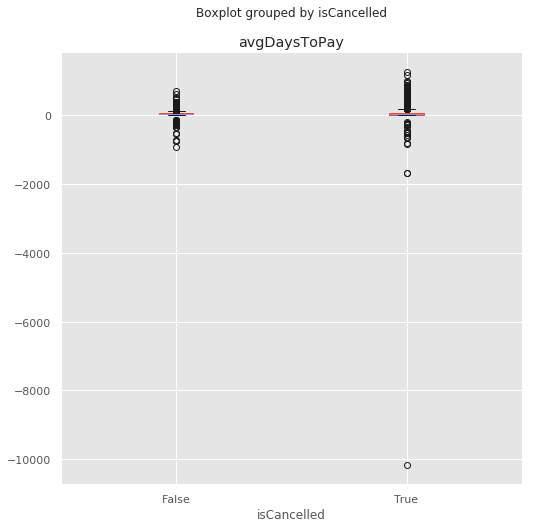

In [118]:
dataFrame.boxplot(column="avgDaysToPay", by= isCancelledKey,figsize= (8,8))  

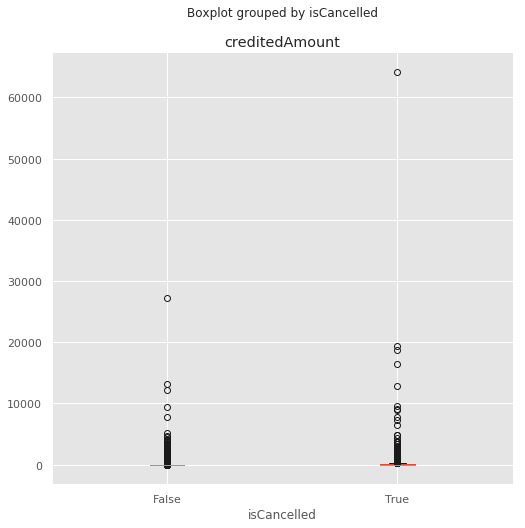

In [119]:
dataFrame.boxplot(column="creditedAmount", by= isCancelledKey,figsize= (8,8))  

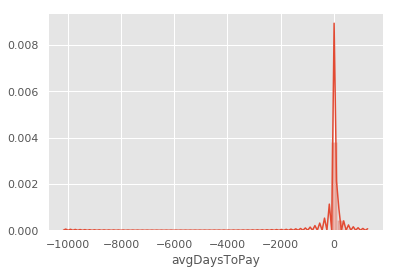

In [120]:
sns.distplot(dataFrame['avgDaysToPay'], kde=True)

In [ ]:
highSkewDf = dataFrame[skewDf.index]
skewGraphs = sns.PairGrid(highSkewDf, hue=isCancelledKey)
skewGraphs = skewGraphs.map_diag(plt.hist)
skewGraphs = skewGraphs.map_offdiag(plt.scatter)
skewGraphs = skewGraphs.add_legend()

KeyError: 'isCancelled'

### Feature selection based on SelectKBest

In [12]:
rfeData = dataFrame.drop(['monthsSinceStarted','firstInvoiceDate',customerIdKey,adminAreaKey,subCountryKey,countryKey,avgDaysToPay], axis=1)
rfeData[(rfeData > 0.0).all(1)]
rfeData.head()

,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,creditedAmount,isCancelled,hasProduct1,hasProduct2,hasProduct3,hasProduct4,hasProduct5,hasProduct6,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12
0,159.2,159.2,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True
1,239.0,239.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True
2,239.0,239.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True
3,125.0,125.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True
4,125.0,125.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True


In [59]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
import numpy
scoresDatasetArray = []

X = rfeData.drop([isCancelledKey], axis=1)
numCols = len(X.columns)
selector = SelectKBest(chi2, k='all')
fit = selector.fit(X, rfeData['isCancelled'])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)
testScores = selector.scores_
scoresDatasetArray.append(pd.DataFrame({'Fields':X.columns,'Scores':scores, 'Type': 'chi2'}))

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


array([4.35232401e+05, 1.86314085e+04, 1.59523250e+04, 1.36492061e+04,
       1.13637912e+06, 4.00474880e+05, 1.60878509e+05, 1.00848137e+02,
       1.10529559e+02,            nan, 3.33575461e+01, 7.98461538e-01,
                  nan, 3.24772856e+00, 5.39180564e+00, 7.98461538e-01,
       3.84895666e+02, 2.10040591e+01, 4.50110466e+02])

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 9 12] are constant.
  UserWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


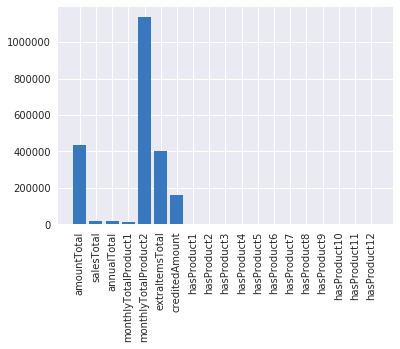

In [63]:
numCols = len(X.columns)
selector2 = SelectKBest(f_classif, k='all')
fit = selector2.fit(X, rfeData['isCancelled'])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector2.pvalues_)

# Plot the scores.
plt.bar(range(numCols), selector.scores_)
plt.xticks(range(numCols), X.columns, rotation='vertical')
plt.show()

In [46]:
numCols = len(X.columns)
selector = SelectKBest(mutual_info_classif, k='all')
fit = selector.fit(X, rfeData['isCancelled'])
scores = selector.scores_
# Get the raw p-values for each feature, and transform from p-values into scores
#scores = -np.log10(selector.pvalues_)
scoresDatasetArray.append(pd.DataFrame({'Fields':X.columns,'Scores':scores, 'Type': 'mutual_info_classif'}))

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


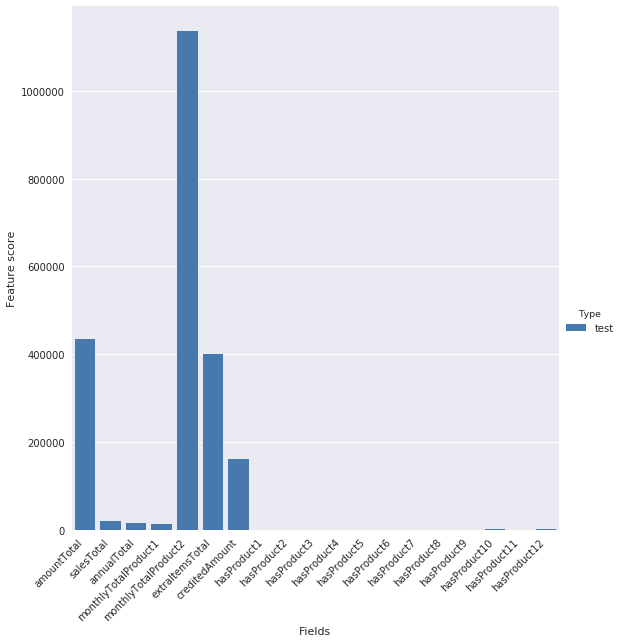

In [58]:
#scoresDataset = pd.concat(scoresDatasetArray)
scoresDataset = pd.DataFrame({'Fields':X.columns,'Scores':testScores, 'Type': 'test'})

groupedBar=sns.factorplot(x='Fields', y='Scores', hue="Type", data=scoresDataset, size=8, kind="bar")
groupedBar.set_ylabels("Feature score")
groupedBar.set_xticklabels(rotation=45,ha='right')

In [61]:
scoresDataset

,Fields,Scores,Type
0,amountTotal,4.352324e+05,test
1,salesTotal,1.863141e+04,test
2,annualTotal,1.595232e+04,test
3,monthlyTotalProduct1,1.364921e+04,test
4,monthlyTotalProduct2,1.136379e+06,test
5,extraItemsTotal,4.004749e+05,test
6,creditedAmount,1.608785e+05,test
7,hasProduct1,1.008481e+02,test
8,hasProduct2,1.105296e+02,test
9,hasProduct3,NaN,test


In [62]:
scoresDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 3 columns):
Fields    19 non-null object
Scores    17 non-null float64
Type      19 non-null object
dtypes: float64(1), object(2)
memory usage: 536.0+ bytes


### One hot encode the categorical columns

In [12]:
categoryFeatures = dataFrame[[adminAreaKey, subCountryKey,countryKey]]
oneHotDataframe = pd.get_dummies(categoryFeatures)
oneHotDataframe[isCancelledKey] = dataFrame[isCancelledKey]
oneHotDataframe[customerIdKey] = dataFrame[customerIdKey]
oneHotDataframe.describe()

,administrativeArea_1 Not Applicable,administrativeArea_ABERDEEN,administrativeArea_ABERDEENSHIRE,administrativeArea_ANGLESEY,administrativeArea_ANGUS,administrativeArea_ARGYLL AND BUTE,administrativeArea_Australia,administrativeArea_BARKING AND DAGENHAM,administrativeArea_BARNET,administrativeArea_BARNSLEY,...,country_Belgium,country_Botswana,country_Congo,country_Germany,country_Ireland,country_Luxembourg,country_Mozambique,country_Nigeria,country_United Kingdom,customerId
count,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,...,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000
mean,0.001069,0.000428,0.000642,0.000428,0.001925,0.000214,0.019461,0.001283,0.001711,0.006202,...,0.000214,0.000214,0.000214,0.000428,0.005133,0.000214,0.000214,0.000214,0.973054,46900.834474
std,0.032686,0.020679,0.025324,0.020679,0.043834,0.014624,0.138154,0.035802,0.041332,0.078516,...,0.014624,0.014624,0.014624,0.020679,0.071466,0.014624,0.014624,0.014624,0.161943,67281.977821
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3808.750000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11919.500000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,38661.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,215093.000000


In [34]:
oneHotDataframe.head()

,administrativeArea_1 Not Applicable,administrativeArea_ABERDEEN,administrativeArea_ABERDEENSHIRE,administrativeArea_ANGLESEY,administrativeArea_ANGUS,administrativeArea_ARGYLL AND BUTE,administrativeArea_Australia,administrativeArea_BARKING AND DAGENHAM,administrativeArea_BARNET,administrativeArea_BARNSLEY,...,country_Botswana,country_Congo,country_Germany,country_Ireland,country_Luxembourg,country_Mozambique,country_Nigeria,country_United Kingdom,isCancelled,customerId
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,False,215093
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,False,215092
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,False,215091
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,False,215090
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,False,215089


In [35]:
oneHotDataframe.corr()[isCancelledKey].sort_values()

customerId                                        -0.163728
country_United Kingdom                            -0.149017
administrativeArea_Durham                         -0.052528
administrativeArea_WESTERN AREA                   -0.051204
subCountryArea_North West                         -0.050434
administrativeArea_WIGAN                          -0.046347
subCountryArea_Northern Ireland                   -0.045127
subCountryArea_Wales                              -0.044419
administrativeArea_CARMARTHENSHIRE                -0.042566
subCountryArea_North East                         -0.040826
subCountryArea_Yorkshire and the Humber           -0.037886
administrativeArea_SWANSEA                        -0.034012
subCountryArea_none                               -0.033640
administrativeArea_PORTSMOUTH                     -0.033211
administrativeArea_CALDERDALE                     -0.032211
administrativeArea_LANCASHIRE                     -0.032098
administrativeArea_none                 

In [13]:
# merge the one hot encoded dataframe to the main dataframe
dataFrame = dataFrame.merge(oneHotDataframe, on=customerIdKey)

In [14]:
list(dataFrame)

['id',
 'amountTotal',
 'salesTotal',
 'annualMaintenanceTotal',
 'phoneBillTotalProduct1',
 'phoneBillTotalProduct2',
 'textBundleTotal',
 'monthsSinceStarted',
 'avgMonthsSincePaid',
 'credited',
 'isCancelled_x',
 'hasProduct1',
 'hasProduct2',
 'hasProduct3',
 'hasProduct4',
 'hasProduct5',
 'hasProduct6',
 'hasProduct7',
 'hasProduct8',
 'hasProduct9',
 'hasProduct10',
 'hasProduct11',
 'hasProduct12',
 'localAuthority',
 'SubCountryArea',
 'SubCountry',
 'firstInvoiceDate',
 'SubCountryArea_Crown dependency',
 'SubCountryArea_East',
 'SubCountryArea_East Midlands',
 'SubCountryArea_London',
 'SubCountryArea_None UK',
 'SubCountryArea_North East',
 'SubCountryArea_North West',
 'SubCountryArea_Northern Ireland',
 'SubCountryArea_Scotland',
 'SubCountryArea_South East',
 'SubCountryArea_South West',
 'SubCountryArea_Wales',
 'SubCountryArea_West Midlands',
 'SubCountryArea_Yorkshire and the Humber',
 'SubCountryArea_none',
 'SubCountry_Australia',
 'SubCountry_Bahamas',
 'SubCountr

In [15]:
# sort the cancelled col out
dataFrame = dataFrame.drop([isCancelledKey+'_y'], axis=1)
dataFrame = dataFrame.rename(columns={isCancelledKey+'_x': isCancelledKey})
list(dataFrame)

['id',
 'amountTotal',
 'salesTotal',
 'annualMaintenanceTotal',
 'phoneBillTotalProduct1',
 'phoneBillTotalProduct2',
 'textBundleTotal',
 'monthsSinceStarted',
 'avgMonthsSincePaid',
 'credited',
 'isCancelled',
 'hasProduct1',
 'hasProduct2',
 'hasProduct3',
 'hasProduct4',
 'hasProduct5',
 'hasProduct6',
 'hasProduct7',
 'hasProduct8',
 'hasProduct9',
 'hasProduct10',
 'hasProduct11',
 'hasProduct12',
 'localAuthority',
 'SubCountryArea',
 'SubCountry',
 'firstInvoiceDate',
 'SubCountryArea_Crown dependency',
 'SubCountryArea_East',
 'SubCountryArea_East Midlands',
 'SubCountryArea_London',
 'SubCountryArea_None UK',
 'SubCountryArea_North East',
 'SubCountryArea_North West',
 'SubCountryArea_Northern Ireland',
 'SubCountryArea_Scotland',
 'SubCountryArea_South East',
 'SubCountryArea_South West',
 'SubCountryArea_Wales',
 'SubCountryArea_West Midlands',
 'SubCountryArea_Yorkshire and the Humber',
 'SubCountryArea_none',
 'SubCountry_Australia',
 'SubCountry_Bahamas',
 'SubCountry_

### Investigate `Feature binning` and `Log transform` for skewed data columns

In [16]:
dataFrame['avgMonthsSincePaid'].describe()

count    4493.000000
mean        2.139996
std        13.022456
min      -801.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        41.000000
Name: avgMonthsSincePaid, dtype: float64

In [17]:
# look at the range of values for the totals
dataFrame['amountTotal'].describe()

count      4493.000000
mean       8346.730824
std       13445.190360
min           0.000000
25%         716.860000
50%        2809.230000
75%        9553.120000
max      222980.524000
Name: amountTotal, dtype: float64

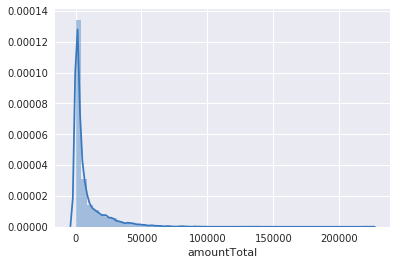

In [18]:
sns.distplot(dataFrame['amountTotal'], kde=True) #, rug=True, rug_kws={"color": "r"}

In [19]:
dataFrame['salesTotal'].describe()

count     4493.000000
mean      1125.670509
std       2177.759327
min          0.000000
25%        149.000000
50%        325.000000
75%        947.000000
max      35128.470000
Name: salesTotal, dtype: float64

In [20]:
dataFrame['annualMaintenanceTotal'].describe()

count     4493.000000
mean      2686.634169
std       4168.182306
min          0.000000
25%        250.000000
50%       1035.000000
75%       3260.000000
max      79443.780000
Name: annualMaintenanceTotal, dtype: float64

In [21]:
dataFrame['phoneBillTotalProduct1'].describe()

count     4493.000000
mean      1770.034800
std       4197.956211
min          0.000000
25%          0.000000
50%          0.000000
75%       1076.130000
max      39997.720000
Name: phoneBillTotalProduct1, dtype: float64

In [22]:
dataFrame['phoneBillTotalProduct2'].describe()

count      4493.000000
mean       2577.947718
std        6590.644769
min           0.000000
25%           0.000000
50%         161.950000
75%        2219.040000
max      165385.930000
Name: phoneBillTotalProduct2, dtype: float64

In [23]:
dataFrame['credited'].describe()

count     4493.000000
mean       200.482008
std       1325.394725
min          0.000000
25%          0.000000
50%          0.000000
75%          0.100000
max      64171.440000
Name: credited, dtype: float64

In [24]:
dataFrame['credited'].describe()

count     4493.000000
mean       200.482008
std       1325.394725
min          0.000000
25%          0.000000
50%          0.000000
75%          0.100000
max      64171.440000
Name: credited, dtype: float64

#### Feature binning

In [25]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = dataFrame['amountTotal'].quantile(quantile_list)
quantiles

0.00         0.000
0.25       716.860
0.50      2809.230
0.75      9553.120
1.00    222980.524
Name: amountTotal, dtype: float64

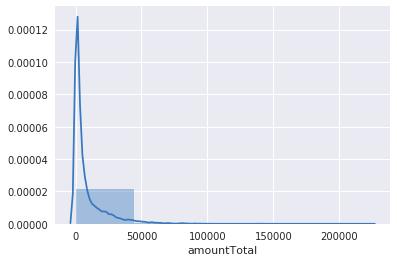

In [26]:
sns.distplot(dataFrame['amountTotal'], kde=True, bins=5) #rug=True, rug_kws={"color": "r"},

Text(0,0.5,'Frequency')

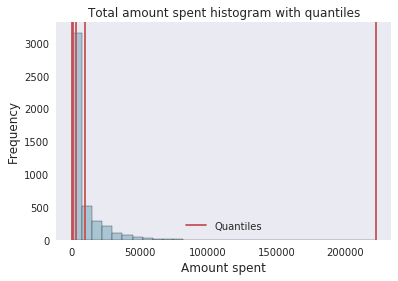

In [27]:
fig, ax = plt.subplots()
dataFrame['amountTotal'].hist(bins=30, color='#A9C5D3', edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Total amount spent histogram with quantiles', fontsize=12)
ax.set_xlabel('Amount spent', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

#### Log transform

In [28]:
dataFrame['amountTotal_log'] = np.log((1+ dataFrame['amountTotal']))

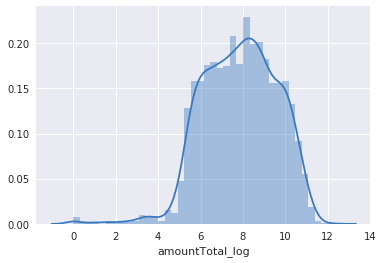

In [29]:
sns.distplot(dataFrame['amountTotal_log'], kde=True)

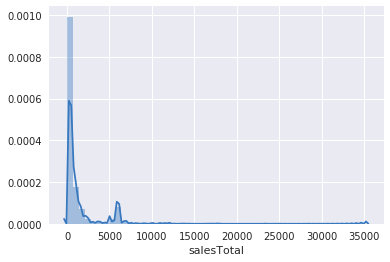

In [30]:
sns.distplot(dataFrame['salesTotal'], kde=True)

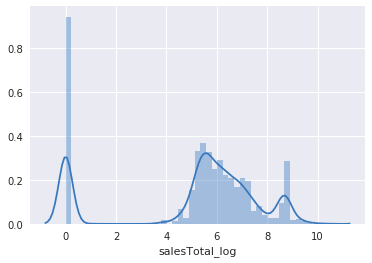

In [31]:
dataFrame['salesTotal_log'] = np.log((1+ dataFrame['salesTotal']))
sns.distplot(dataFrame['salesTotal_log'], kde=True)

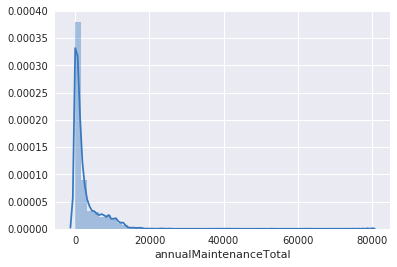

In [32]:
sns.distplot(dataFrame['annualMaintenanceTotal'], kde=True)

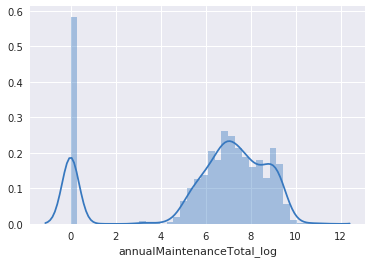

In [33]:
dataFrame['annualMaintenanceTotal_log'] = np.log((1+ dataFrame['annualMaintenanceTotal']))
sns.distplot(dataFrame['annualMaintenanceTotal_log'], kde=True)

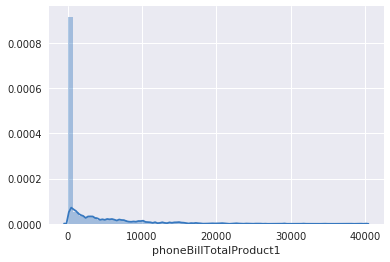

In [34]:
sns.distplot(dataFrame['phoneBillTotalProduct1'], kde=True)

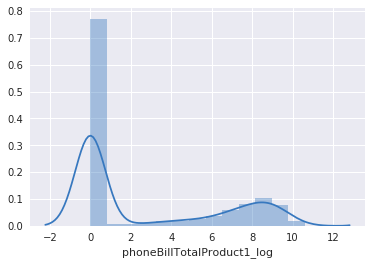

In [35]:
dataFrame['phoneBillTotalProduct1_log'] = np.log((1+ dataFrame['phoneBillTotalProduct1']))
sns.distplot(dataFrame['phoneBillTotalProduct1_log'], kde=True)

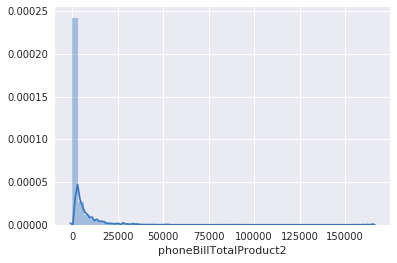

In [36]:
sns.distplot(dataFrame['phoneBillTotalProduct2'], kde=True)

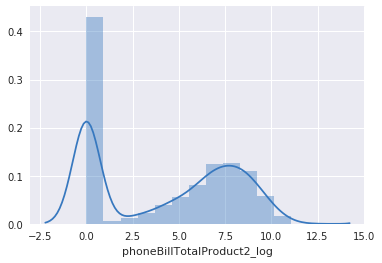

In [37]:
dataFrame['phoneBillTotalProduct2_log'] = np.log((1+ dataFrame['phoneBillTotalProduct2']))
sns.distplot(dataFrame['phoneBillTotalProduct2_log'], kde=True)

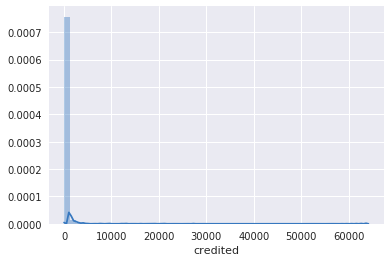

In [38]:
sns.distplot(dataFrame['credited'], kde=True)

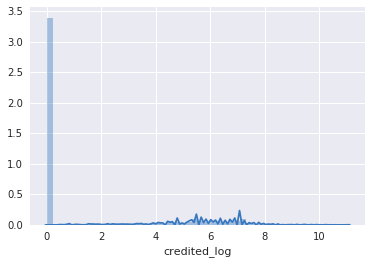

In [39]:
dataFrame['credited_log'] = np.log((1+ dataFrame['credited']))
sns.distplot(dataFrame['credited_log'], kde=True)

# Paired Density and Scatterplot Matrix - Money columns

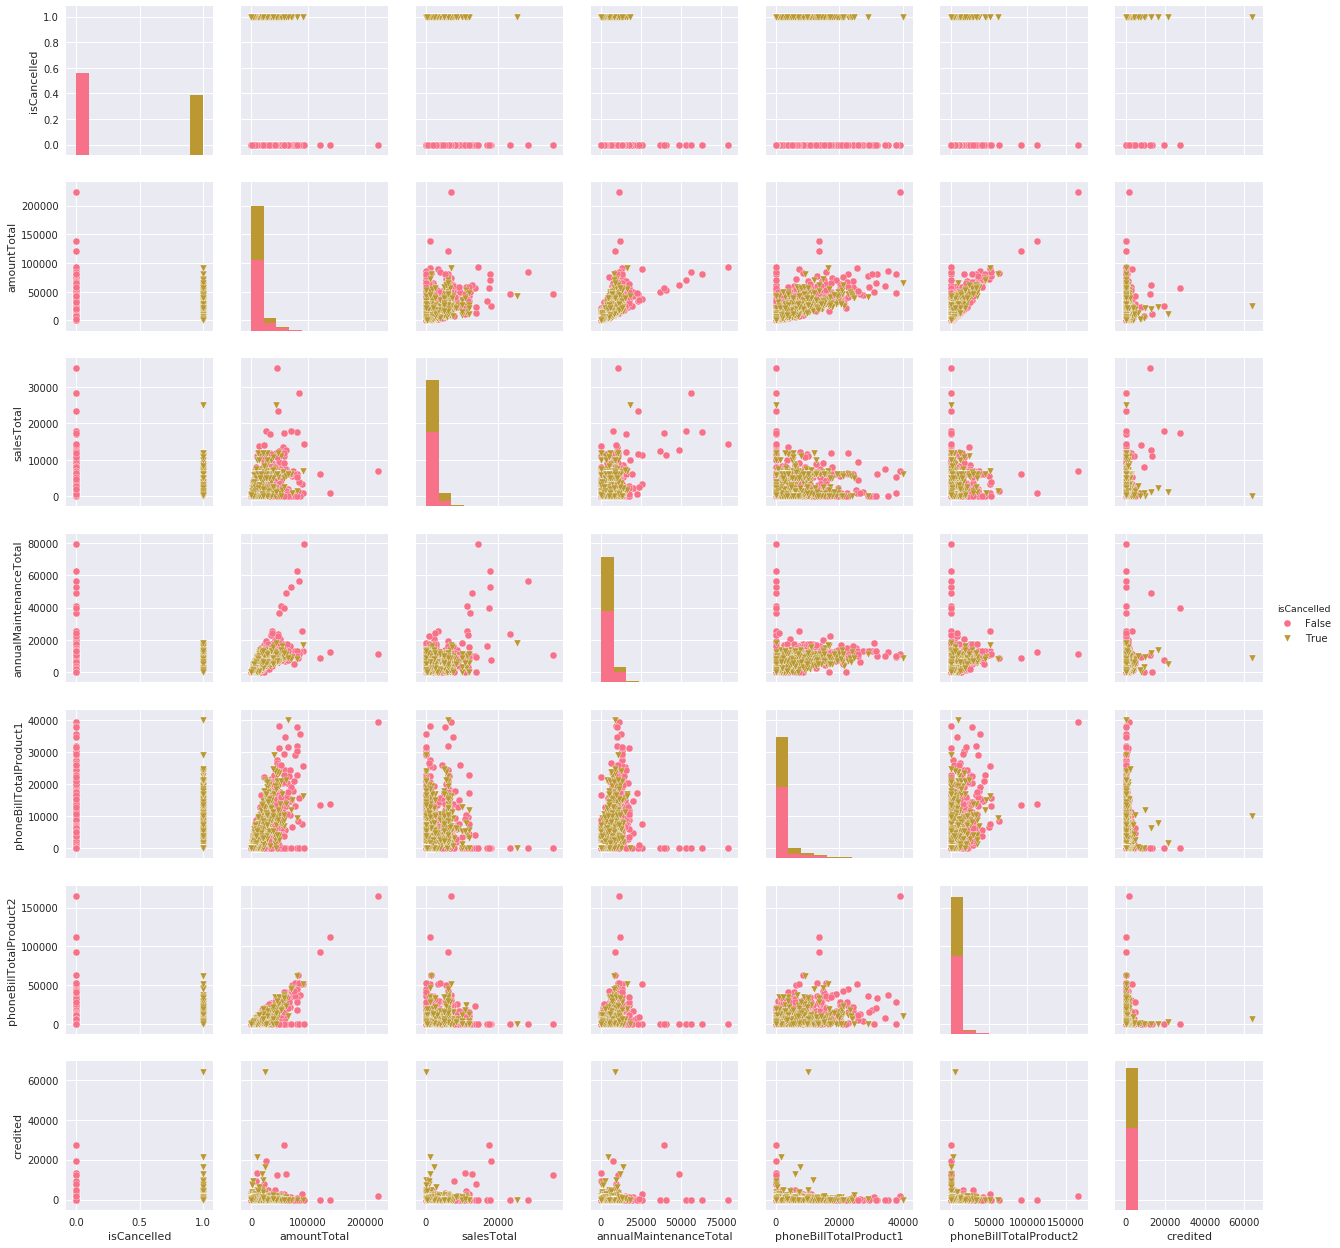

In [40]:
justMoneyDataFrame = dataFrame[['isCancelled','amountTotal','salesTotal','annualMaintenanceTotal','phoneBillTotalProduct1','phoneBillTotalProduct2','credited']]
palette = sns.color_palette("husl", 6)
markers = ['o','v']
graphs = sns.pairplot(justMoneyDataFrame, hue=isCancelledKey, palette=palette, markers=markers)

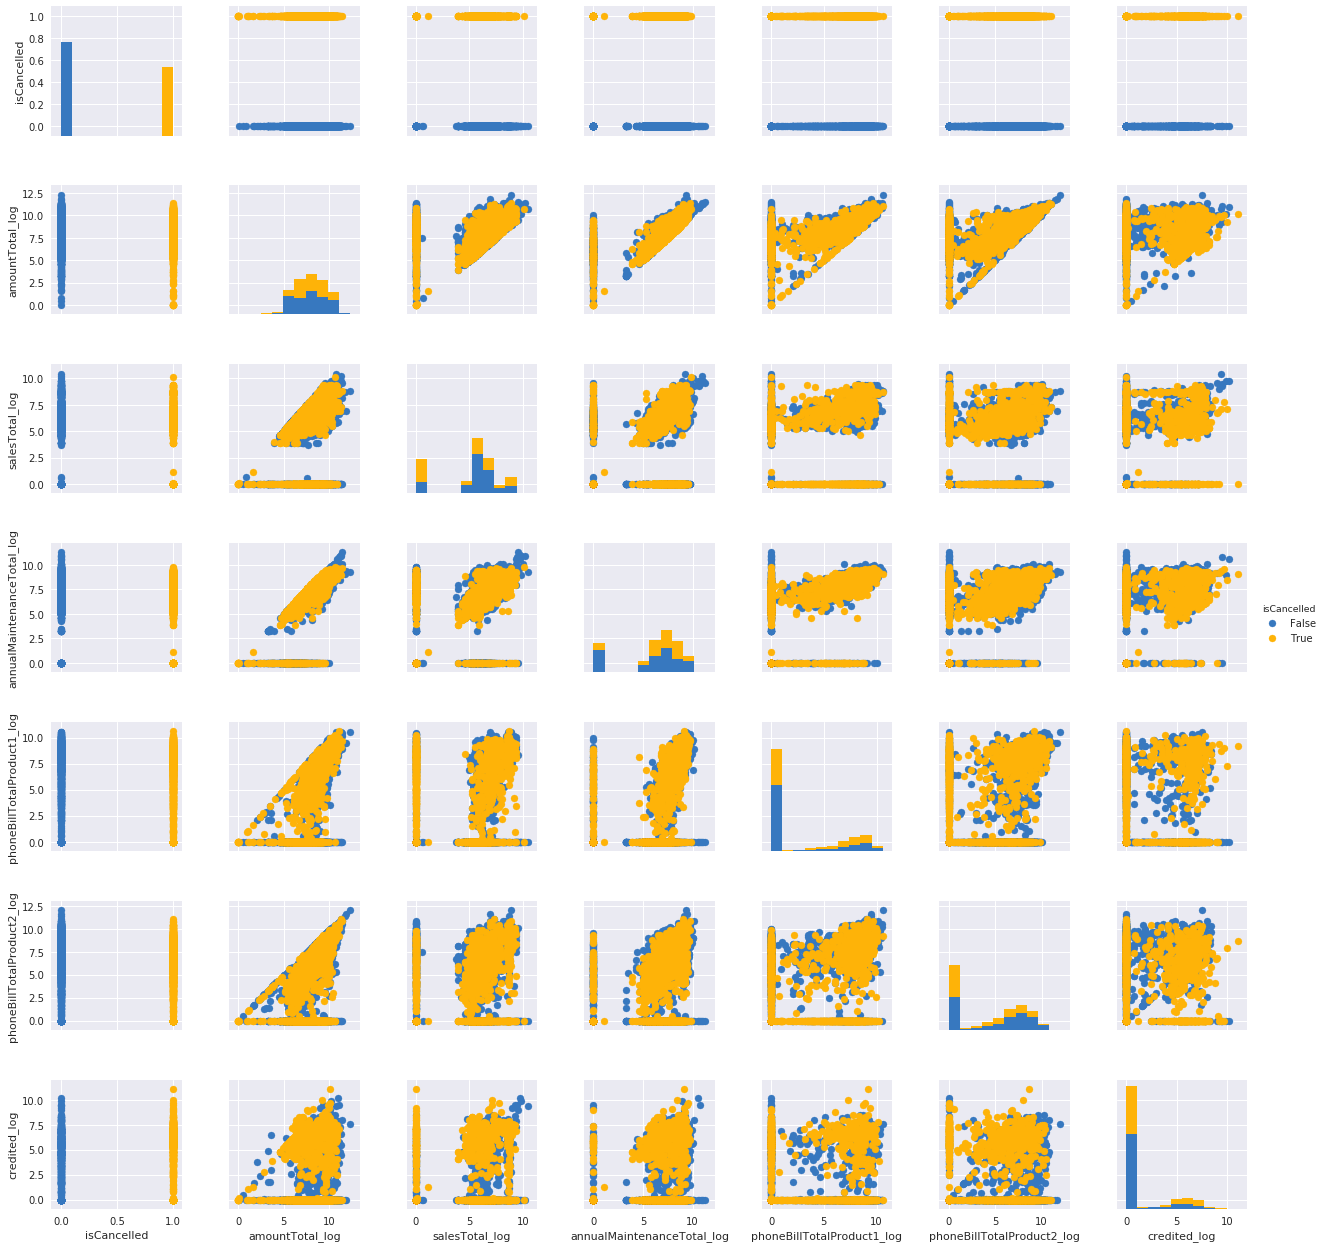

In [41]:
justMoneyLogDataFrame = dataFrame[['isCancelled','amountTotal_log','salesTotal_log','annualMaintenanceTotal_log','phoneBillTotalProduct1_log','phoneBillTotalProduct2_log','credited_log']]
logGraphs = sns.PairGrid(justMoneyLogDataFrame, hue=isCancelledKey)
logGraphs = logGraphs.map_diag(plt.hist)
logGraphs = logGraphs.map_offdiag(plt.scatter)
logGraphs = logGraphs.add_legend()

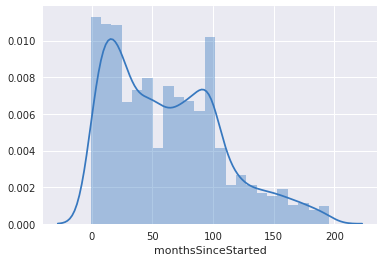

In [42]:
sns.distplot(dataFrame['monthsSinceStarted'], kde=True)

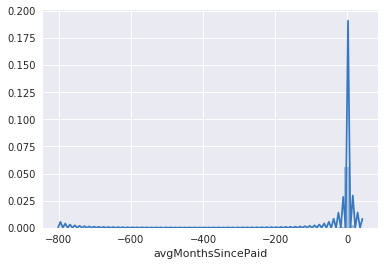

In [43]:
sns.distplot(dataFrame['avgMonthsSincePaid'], kde=True)

## Random forest feature classifier

In [44]:
dataFrame.describe()

,id,amountTotal,salesTotal,annualMaintenanceTotal,phoneBillTotalProduct1,phoneBillTotalProduct2,textBundleTotal,monthsSinceStarted,avgMonthsSincePaid,credited,...,localAuthority_Westminster,localAuthority_Wokingham,localAuthority_YORK,localAuthority_none,amountTotal_log,salesTotal_log,annualMaintenanceTotal_log,phoneBillTotalProduct1_log,phoneBillTotalProduct2_log,credited_log
count,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,...,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000
mean,43899.254618,8346.730824,1125.670509,2686.634169,1770.034800,2577.947718,186.429955,62.260850,2.139996,200.482008,...,0.001558,0.002226,0.007122,0.041175,7.860314,5.083837,6.055560,2.744907,4.240154,1.375179
std,64795.280764,13445.190360,2177.759327,4168.182306,4197.956211,6590.644769,926.158489,45.772134,13.022456,1325.394725,...,0.039445,0.047130,0.084101,0.198717,1.731280,2.831876,3.046055,3.763806,3.762189,2.534941
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-801.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3671.000000,716.860000,149.000000,250.000000,0.000000,0.000000,0.000000,23.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.576275,5.010635,5.525453,0.000000,0.000000,0.000000
50%,11829.000000,2809.230000,325.000000,1035.000000,0.000000,161.950000,0.000000,57.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,7.941022,5.786897,6.943122,0.000000,5.093443,0.000000
75%,38131.000000,9553.120000,947.000000,3260.000000,1076.130000,2219.040000,0.000000,94.000000,3.000000,0.100000,...,0.000000,0.000000,0.000000,0.000000,9.164728,6.854355,8.089789,6.982055,7.705280,0.095310
max,215052.000000,222980.524000,35128.470000,79443.780000,39997.720000,165385.930000,19850.000000,196.000000,41.000000,64171.440000,...,1.000000,1.000000,1.000000,1.000000,12.314844,10.466796,11.282817,10.596603,12.016043,11.069329


In [109]:
features = dataFrame.drop(['firstInvoiceDate',customerIdKey,'SubCountryArea','SubCountry','localAuthority'], axis=1)
response = dataFrame[isCancelledKey]

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(features, response)
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
feat_labels = features.columns[1:]

In [110]:
for f in range(features.shape[1]):
    print("%2d) %-*s %f" % (f, 60, feat_labels[indices[f]-1], importances[indices[f]])) 

 0) isCancelled                                                  0.479208
 1) monthsSinceStarted                                           0.051456
 2) hasProduct10                                                 0.038180
 3) hasProduct12                                                 0.029805
 4) salesTotal_log                                               0.027429
 5) amountTotal_log                                              0.025211
 6) annualMaintenanceTotal_log                                   0.025001
 7) salesTotal                                                   0.024894
 8) phoneBillTotalProduct2                                       0.024199
 9) hasProduct2                                                  0.024181
10) annualMaintenanceTotal                                       0.023359
11) phoneBillTotalProduct2_log                                   0.023263
12) credited_log                                                 0.022868
13) avgMonthsSincePaid                

In [111]:
sfm = SelectFromModel(rfc, threshold=0.006242,prefit=True)
outcome = sfm.get_support(indices=True)
shortenFeatures = features.iloc[:,outcome]
shortenFeatures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4493 entries, 0 to 4492
Data columns (total 20 columns):
amountTotal                   4493 non-null float64
salesTotal                    4493 non-null float64
annualMaintenanceTotal        4493 non-null float64
phoneBillTotalProduct1        4493 non-null float64
phoneBillTotalProduct2        4493 non-null float64
textBundleTotal               4493 non-null float64
monthsSinceStarted            4493 non-null int64
avgMonthsSincePaid            4493 non-null int64
credited                      4493 non-null float64
isCancelled                   4493 non-null bool
hasProduct1                   4493 non-null bool
hasProduct2                   4493 non-null bool
hasProduct10                  4493 non-null bool
hasProduct12                  4493 non-null bool
amountTotal_log               4493 non-null float64
salesTotal_log                4493 non-null float64
annualMaintenanceTotal_log    4493 non-null float64
phoneBillTotalProduct1_log  

# Enough engineering - models!

First we need a base line to compare the predicts with, as the output is a boolean we can use a `True` prediction for every row of observations in the test set. As this is a binary classifier we can use a majority class classifier:

In [124]:
shortenFeatures[isCancelledKey]

0       False
1       False
2        True
3        True
4       False
5       False
6        True
7       False
8       False
9       False
10       True
11      False
12      False
13       True
14      False
15      False
16       True
17      False
18      False
19       True
20       True
21      False
22      False
23      False
24      False
25      False
26       True
27       True
28       True
29       True
30      False
31       True
32      False
33      False
34      False
35      False
36      False
37       True
38       True
39      False
40       True
41       True
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
        ...  
4443    False
4444    False
4445    False
4446     True
4447     True
4448     True
4449     True
4450    False
4451    False
4452    False
4453    False
4454     True
4455    False
4456    False
4457    False
4458    False
4459    False
4460     True
4461    False
4462     True
4463  

In [129]:
# Split into training/testing sets with 25% split
# Remove cols with limited importance
# remove the dependant col!
selectedFeatures = dataFrame.drop([isCancelledKey,'hasProduct3','hasProduct6','hasProduct9','hasProduct5','hasProduct7','hasProduct11','hasProduct8','hasProduct4','firstInvoiceDate',customerIdKey,'SubCountryArea','SubCountry','localAuthority'], axis=1)
y = dataFrame[isCancelledKey]
X_train, X_test, y_train, y_test = train_test_split(selectedFeatures, y, test_size = 0.25, stratify=y)

In [131]:
shortenNoCancelled = shortenFeatures.drop(isCancelledKey, axis=1)
shortenY = shortenFeatures[isCancelledKey]
shortenX_train, shortenX_test, shorteny_train, shorteny_test = train_test_split(shortenNoCancelled, shortenY, test_size = 0.25, stratify=shortenY)

In [114]:
def showConfusionMatrix(title, y_test, y_predicted):
    confusionMatrix = confusion_matrix(y_test, y_predicted, labels=list(set(y_test)))
    confusionMatrix = pd.DataFrame(confusionMatrix, index=["Actual Positive", "Actual Negative"], columns = ["Predicted Positive", "Predicted Negative"])
    print(title+" - Confusion Matrix" )
    print(tabulate(confusionMatrix, tablefmt="orgtbl", headers="keys"))
    print("Model accuracy = %0.2f"%(accuracy_score(y_test,y_predicted) * 100) + "%\n") 

In [115]:
def pltRoc(plt):
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [116]:
def trainAndPlot(X_train, X_test, y_train, y_test,includeSvc = False):
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    y_probas = dummy.predict_proba(X_test)
    y_predicted = dummy.predict(X_test)
    showConfusionMatrix('Baseline',y_test, y_predicted)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probas[:, 1])
    area_under_the_curve = auc(false_positive_rate, true_positive_rate)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    knnModel = KNeighborsClassifier()
    knnModel.fit(X_train, y_train)
    knn_y_predict = knnModel.predict(X_test)
    knn_y_probas = knnModel.predict_proba(X_test)
    showConfusionMatrix('KNN', y_test, knn_y_predict)
    
    knn_false_positive_rate, knn_true_positive_rate, knn_thresholds = roc_curve(y_test, knn_y_probas[:, 1])
    knn_area_under_the_curve = auc(knn_false_positive_rate, knn_true_positive_rate)
    knn_roc_auc = auc(knn_false_positive_rate, knn_true_positive_rate)
    
    lrModel = LogisticRegression()
    lrModel.fit(X_train, y_train)

    lr_predict_probabilities = lrModel.predict_proba(X_test)
    lr_y_predict = lrModel.predict(X_test)
    lr_y_probas = lrModel.predict_proba(X_test)
    showConfusionMatrix('Logistic regression',y_test, lr_y_predict)
    
    lr_false_positive_rate, lr_true_positive_rate, lr_thresholds = roc_curve(y_test, lr_y_probas[:, 1])
    lr_area_under_the_curve = auc(lr_false_positive_rate, lr_true_positive_rate)
    lr_roc_auc = auc(lr_false_positive_rate, lr_true_positive_rate)
    
    if(includeSvc):
        #SvcModel = SVC(probability=True, kernel='linear')
        SvcModel = SVC(kernel="linear", C=0.025, probability=True)
        SvcModel.fit(X_train, y_train)

        Svc_predict_probabilities = SvcModel.predict_proba(X_test)
        Svc_y_predict = SvcModel.predict(X_test)
        Svc_y_probas = SvcModel.predict_proba(X_test)
        showConfusionMatrix('SVM', y_test, Svc_y_predict)

        Svc_false_positive_rate, Svc_true_positive_rate, Svc_thresholds = roc_curve(y_test, Svc_y_probas[:, 1])
        Svc_area_under_the_curve = auc(Svc_false_positive_rate, Svc_true_positive_rate)
        Svc_roc_auc = auc(Svc_false_positive_rate, Svc_true_positive_rate)
    
    NbModel = GaussianNB()
    NbModel.fit(X_train, y_train)

    Nb_predict_probabilities = NbModel.predict_proba(X_test)
    Nb_y_predict = NbModel.predict(X_test)
    Nb_y_probas = NbModel.predict_proba(X_test)
    showConfusionMatrix('Gaussian Navie Bayes', y_test, Nb_y_predict)
    
    Nb_false_positive_rate, Nb_true_positive_rate, Nb_thresholds = roc_curve(y_test, Nb_y_probas[:, 1])
    Nb_area_under_the_curve = auc(Nb_false_positive_rate, Nb_true_positive_rate)
    Nb_roc_auc = auc(Nb_false_positive_rate, Nb_true_positive_rate)
    
    DtModel = DecisionTreeClassifier()
    DtModel.fit(X_train, y_train)

    Dt_predict_probabilities = DtModel.predict_proba(X_test)
    Dt_y_predict = DtModel.predict(X_test)
    Dt_y_probas = DtModel.predict_proba(X_test)
    Dt_false_positive_rate, Dt_true_positive_rate, Dt_thresholds = roc_curve(y_test, Dt_y_probas[:, 1])
    Dt_area_under_the_curve = auc(Dt_false_positive_rate, Dt_true_positive_rate)
    Dt_roc_auc = auc(Dt_false_positive_rate, Dt_true_positive_rate)

    showConfusionMatrix('Decision Tree Classifier',y_test, Dt_y_predict)
    
    print('Baseline ROC AUC: %0.2f' % roc_auc)
    print('KNN ROC AUC: %0.2f' % knn_roc_auc)
    print('LR ROC AUC: %0.2f' % lr_roc_auc)
    if(includeSvc):
        print('SVC ROC AUC: %0.2f' % Svc_roc_auc)
    print('NB ROC AUC: %0.2f' % Nb_roc_auc)
    print('DT ROC AUC: %0.2f' % Dt_roc_auc)

    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, label='Baseline area = %0.2f)' % roc_auc)
    plt.plot(knn_false_positive_rate, knn_true_positive_rate, label='KNN area = %0.2f)' % knn_roc_auc)
    plt.plot(lr_false_positive_rate, lr_true_positive_rate, label='LR area = %0.2f)' % lr_roc_auc)
    plt.plot(Nb_false_positive_rate, Nb_true_positive_rate, label='Nb area = %0.2f)' % Nb_roc_auc)
    plt.plot(Dt_false_positive_rate, Dt_true_positive_rate, label='DT area = %0.2f)' % Dt_roc_auc)
    if(includeSvc):
        plt.plot(Svc_false_positive_rate, Svc_true_positive_rate, label='SVC area = %0.2f)' % Svc_roc_auc)
    pltRoc(plt)

# ROC curve and accuracy of predictions

Baseline - Confusion Matrix
|                 |   Predicted Positive |   Predicted Negative |
|-----------------+----------------------+----------------------|
| Actual Positive |                  649 |                    0 |
| Actual Negative |                  475 |                    0 |
Model accuracy = 57.74%

KNN - Confusion Matrix
|                 |   Predicted Positive |   Predicted Negative |
|-----------------+----------------------+----------------------|
| Actual Positive |                  501 |                  148 |
| Actual Negative |                  175 |                  300 |
Model accuracy = 71.26%

Logistic regression - Confusion Matrix
|                 |   Predicted Positive |   Predicted Negative |
|-----------------+----------------------+----------------------|
| Actual Positive |                  570 |                   79 |
| Actual Negative |                  126 |                  349 |
Model accuracy = 81.76%

Gaussian Navie Bayes - Confusion Matrix
|  

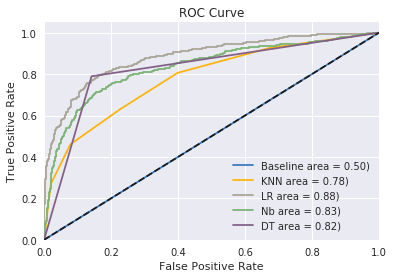

In [117]:
trainAndPlot(X_train, X_test, y_train, y_test, False)

# Limit the dataset and retest

Baseline - Confusion Matrix
|                 |   Predicted Positive |   Predicted Negative |
|-----------------+----------------------+----------------------|
| Actual Positive |                  649 |                    0 |
| Actual Negative |                  475 |                    0 |
Model accuracy = 57.74%

KNN - Confusion Matrix
|                 |   Predicted Positive |   Predicted Negative |
|-----------------+----------------------+----------------------|
| Actual Positive |                  519 |                  130 |
| Actual Negative |                  171 |                  304 |
Model accuracy = 73.22%

Logistic regression - Confusion Matrix
|                 |   Predicted Positive |   Predicted Negative |
|-----------------+----------------------+----------------------|
| Actual Positive |                  576 |                   73 |
| Actual Negative |                  185 |                  290 |
Model accuracy = 77.05%

Gaussian Navie Bayes - Confusion Matrix
|  

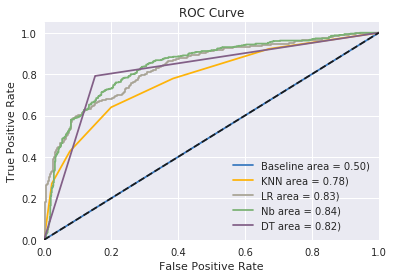

In [132]:
trainAndPlot(shortenX_train, shortenX_test, shorteny_train, shorteny_test, False)